<a href="https://colab.research.google.com/github/kaylawright26/Final-Project-IoT-AAI-530/blob/main/IoT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IoT Final Team Project



### Importing Libraries, Data, and Sanity Checks

In [1]:
# Importing necessary libraries
import numpy as np                                                                               
import pandas as pd 
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences
import tensorflow as tf
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import optimizers

In [2]:
# Mounting google drive to import datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/train_ML_IOT.csv')

In [4]:
# Checking shape of training set
df.shape

(48120, 4)

In [5]:
# Checking count and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
# Checking statistical information on this dataset
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [7]:
# Checking to see the first 5 rows of the dataset
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [8]:
# Dropping ID column because it will not be helpful for our model
df.drop(["ID"], axis = 1, inplace = True)

In [9]:
# Checking for duplicated rows
df[df.duplicated()].count()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

In [10]:
# Checking for nan values
df[df.isna()].count()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

### Feature Engineering

In [11]:
# Converting datetime to unix time
df['DateTime'] = pd.to_datetime(df['DateTime'])
df["unix_time_column"] = df["DateTime"].apply(lambda x: x.timestamp())

In [12]:
# Checking if the datatype conversion worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          48120 non-null  datetime64[ns]
 1   Junction          48120 non-null  int64         
 2   Vehicles          48120 non-null  int64         
 3   unix_time_column  48120 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.5 MB


In [13]:
# Making Weekday, Year, Month, Day, Time, Week, and Quarter
df['Weekday'] = [datetime.weekday(date) for date in df.DateTime]
df['Year'] = [date.year for date in df.DateTime]
df['Month'] = [date.month for date in df.DateTime]
df['Day'] = [date.day for date in df.DateTime]
df['Seconds'] = [((date.hour*60+(date.minute))*60)+date.second for date in df.DateTime]
df['Week'] = [date.week for date in df.DateTime]
df['Quarter'] = [date.quarter for date in df.DateTime]

In [14]:
df.tail()

,DateTime,Junction,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
48115,2017-06-30 19:00:00,4,11,1.498849e+09,4,2017,6,30,68400,26,2
48116,2017-06-30 20:00:00,4,30,1.498853e+09,4,2017,6,30,72000,26,2
48117,2017-06-30 21:00:00,4,16,1.498856e+09,4,2017,6,30,75600,26,2
48118,2017-06-30 22:00:00,4,22,1.498860e+09,4,2017,6,30,79200,26,2
48119,2017-06-30 23:00:00,4,12,1.498864e+09,4,2017,6,30,82800,26,2


### Data Visualization

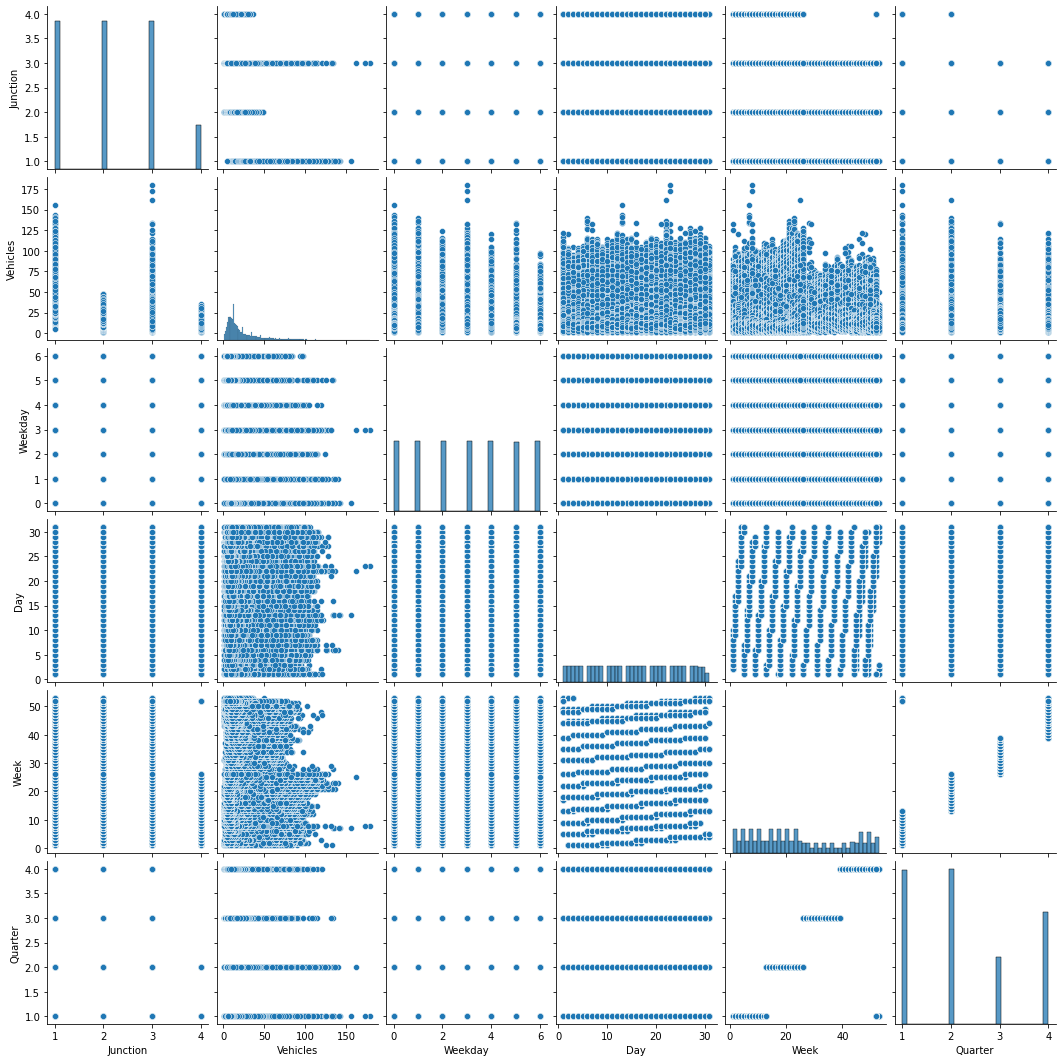

In [15]:
sns.pairplot(df, x_vars = ["Junction", "Vehicles", "Weekday", "Day", "Week", "Quarter"], y_vars = ["Junction", "Vehicles", "Weekday", "Day", "Week", "Quarter"])

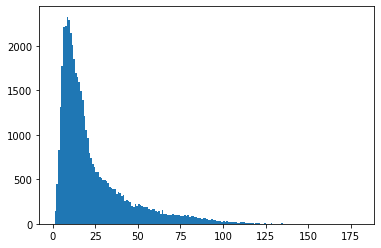

In [16]:
binwidth = 1
plt.hist(df.Vehicles, bins = range(min(df.Vehicles), max(df.Vehicles) + binwidth, binwidth))
plt.show()

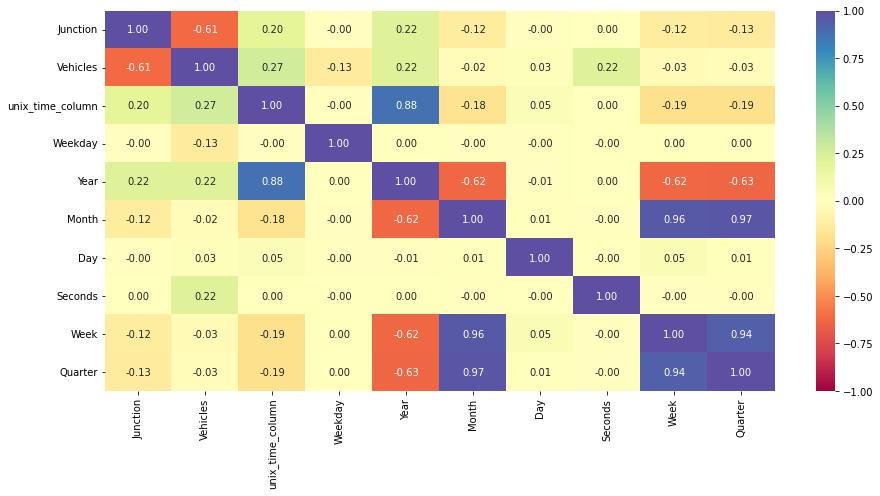

In [17]:
# Code below makes a heatmap to see important correlations
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

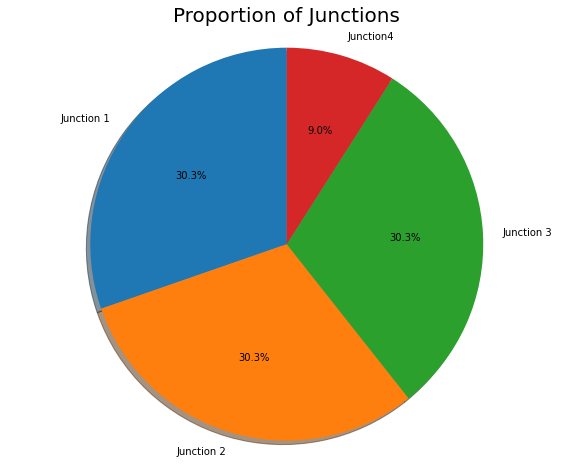

In [18]:
labels = 'Junction 1', 'Junction 2', 'Junction 3', 'Junction4'
sizes = [df.Junction[df['Junction']==1].count(), df.Junction[df['Junction']==2].count(), df.Junction[df['Junction']==3].count(), df.Junction[df['Junction']==4].count()]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Junctions", size = 20)
plt.show()

In [19]:
# class count
class_count_0, class_count_1, class_count_2, class_count_3 = df['Junction'].value_counts()

# Separate class
class_1 = df[df['Junction'] == 1]
class_2 = df[df['Junction'] == 2]
class_3 = df[df['Junction'] == 3]
class_4 = df[df['Junction'] == 4]# print the shape of the class
print('Junction 1:', class_1.shape)
print('Junction 2:', class_2.shape)
print('Junction 3:', class_3.shape)
print('Junction 4:', class_4.shape)

Junction 1: (14592, 11)
Junction 2: (14592, 11)
Junction 3: (14592, 11)
Junction 4: (4344, 11)


In [ ]:
# FIX ME LATER
#class_1_under = class_1.sample(class_count_1)

#test_under = pd.concat([class_0_under, class_1], axis=0)

#print("total class of 1 and0:",test_under['Class'].value_counts())# plot the count after under-sampeling
#test_under['Class'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df, title='Traffic Profile Report', html={'style':{'full_width':True}})
#profile.to_notebook_iframe()

In [ ]:
#analysis = sv.analyze(df)
#analysis.show_notebook() # or export with show_html()

### Model Building

#### LSTM Predicting Vehicles at a Junction

In [20]:
#create your training and validation sets here
#create your training and validation sets here
data_one_percent = int(len(df.index))

#Take Random data subset
data_one_percent_rand = df.iloc[0:data_one_percent,:]

#split data subset 80/20 for train/validation
eighty_percent = int(data_one_percent * 0.8)
train_df = data_one_percent_rand.iloc[0:eighty_percent]
val_df = data_one_percent_rand.drop(train_df.index)

In [21]:
val_df.head()

,DateTime,Junction,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
38496,2016-11-23 00:00:00,3,17,1.479859e+09,2,2016,11,23,0,47,4
38497,2016-11-23 01:00:00,3,12,1.479863e+09,2,2016,11,23,3600,47,4
38498,2016-11-23 02:00:00,3,10,1.479866e+09,2,2016,11,23,7200,47,4
38499,2016-11-23 03:00:00,3,7,1.479870e+09,2,2016,11,23,10800,47,4
38500,2016-11-23 04:00:00,3,4,1.479874e+09,2,2016,11,23,14400,47,4


In [22]:
train_df.shape, val_df.shape

((38496, 11), (9624, 11))

In [23]:
seq_arrays = []
seq_labs = []

In [24]:
# we'll start out with a 3 hour 
seq_length = 3
ph = 1

feat_cols = ['Vehicles']

#create list of sequence length GAP readings
#Based my for loop to go through the sequence length GAP readings by using 
#the Kaggle link: https://www.kaggle.com/code/nilakay/lstm-time-series-iot
for i in range(len(train_df) - seq_length - ph):
    seq = df.iloc[i:i + seq_length][feat_cols].to_numpy()
    seq_arrays.append(seq)
    seq_lab = df.iloc[i+ seq_length + ph][feat_cols].to_numpy()[-1]
    seq_labs.append(seq_lab)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

#Reshape seq_arrays

seq_arrays = seq_arrays.reshape((seq_arrays.shape[0], seq_arrays.shape[1], len(feat_cols)))

In [25]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [26]:
seq_labs = seq_labs.reshape(-1,1)

In [27]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2] #number of features selected with sequence_cols
nb_out = seq_labs.shape[1] #expected output length

model = Sequential()
#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=15, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))
# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out))
model.add(Activation('relu'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 15)             1020      
                                                                 
 dropout (Dropout)           (None, 3, 15)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,071
Trainable params: 2,071
Non-trainabl

In [28]:
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
74/74 - 9s - loss: 902.2958 - mse: 902.2958 - val_loss: 111.8950 - val_mse: 111.8950 - 9s/epoch - 118ms/step
Epoch 2/100
74/74 - 1s - loss: 640.0889 - mse: 640.0889 - val_loss: 76.2676 - val_mse: 76.2676 - 534ms/epoch - 7ms/step
Epoch 3/100
74/74 - 1s - loss: 484.6288 - mse: 484.6288 - val_loss: 56.8342 - val_mse: 56.8342 - 536ms/epoch - 7ms/step
Epoch 4/100
74/74 - 1s - loss: 380.4558 - mse: 380.4558 - val_loss: 52.6862 - val_mse: 52.6862 - 527ms/epoch - 7ms/step
Epoch 5/100
74/74 - 1s - loss: 308.8943 - mse: 308.8943 - val_loss: 50.9345 - val_mse: 50.9345 - 544ms/epoch - 7ms/step
Epoch 6/100
74/74 - 1s - loss: 256.0895 - mse: 256.0895 - val_loss: 55.1692 - val_mse: 55.1692 - 506ms/epoch - 7ms/step
Epoch 7/100
74/74 - 0s - loss: 219.3372 - mse: 219.3372 - val_loss: 51.8603 - val_mse: 51.8603 - 424ms/epoch - 6ms/step
Epoch 8/100
74/74 - 0s - loss: 189.6225 - mse: 189.6225 - val_loss: 52.1442 - val_mse: 52.1442 - 375ms/epoch - 5ms/step
Epoch 9/100
74/74 - 0s - loss: 168.0348

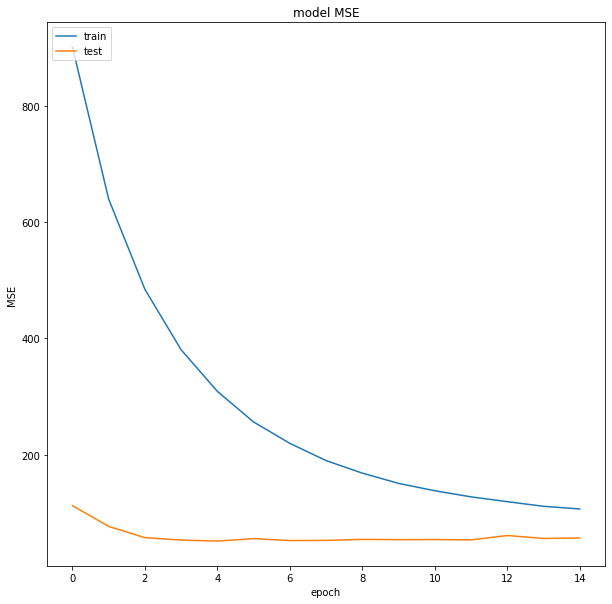

In [29]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

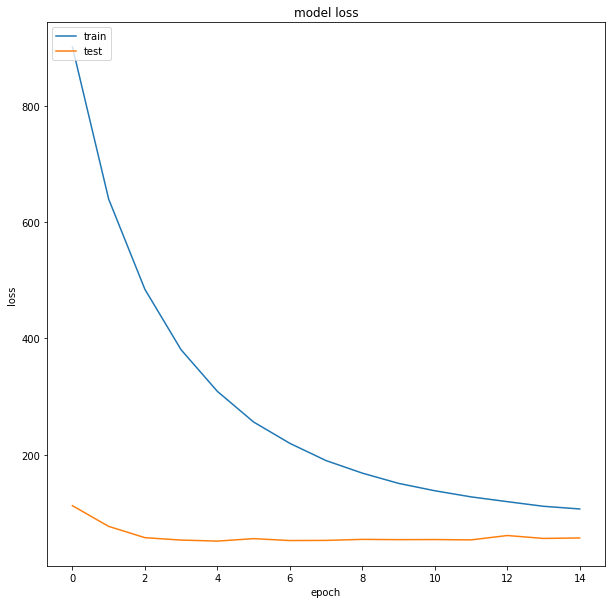

In [30]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [31]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(2,len(val_df) - seq_length - ph):
  if (i < seq_length):
      seq = val_df.iloc[0:i][feat_cols].to_numpy()
      val_arrays.append(seq)
      val_lab = val_df.iloc[i + ph][feat_cols].to_numpy()[-1]
      val_labs.append(val_lab)
  else:
      seq = val_df.iloc[i:i + seq_length][feat_cols].to_numpy()
      val_arrays.append(seq)
      val_lab = val_df.iloc[i + seq_length + ph][feat_cols].to_numpy()[-1]
      val_labs.append(val_lab)
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = tf.keras.utils.pad_sequences(
    val_arrays,
    maxlen=None,
    dtype='float32',
    padding='pre',
    truncating='pre',
    value=0.0
)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

301/301 - 2s - loss: 48.1341 - mse: 48.1186 - 2s/epoch - 8ms/step

MSE: 48.11856460571289
301/301 [==============================] - 1s 2ms/step


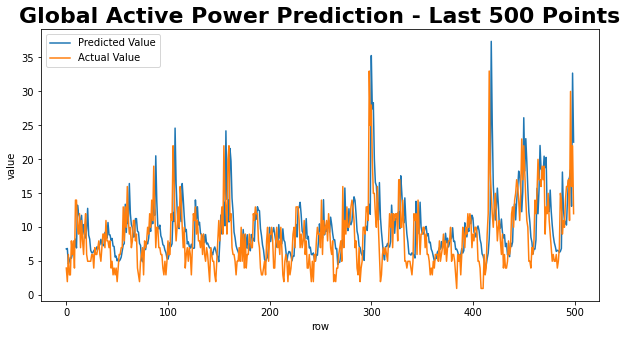

In [32]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('/content/drive/My Drive/submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [33]:
sub = pd.merge(val_df, test_set, left_index = True, right_index = True)
sub.to_csv('/content/drive/My Drive/projectlstm.csv')

### Junction Prediction Using A Neural Network

- do not use sigmoid in output layer, use softmax
- or none at all in hidden layers

In [34]:
# One hot encouding junction
one_hot_encoded = pd.get_dummies(df, columns=["Junction"]) # Drop First?
X = one_hot_encoded.drop(['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4', 'DateTime'],axis=1)
y = one_hot_encoded[['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4']]

In [35]:
X.head()

,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
0,15,1.446336e+09,6,2015,11,1,0,44,4
1,13,1.446340e+09,6,2015,11,1,3600,44,4
2,10,1.446343e+09,6,2015,11,1,7200,44,4
3,7,1.446347e+09,6,2015,11,1,10800,44,4
4,9,1.446350e+09,6,2015,11,1,14400,44,4


In [36]:
y.head()

,Junction_1,Junction_2,Junction_3,Junction_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [37]:
X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,shuffle = True)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True)

### NN Model 1 (No sampling)

In [39]:
#Initializing the neural network
model_1 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_1.add(Dense(16,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_1.add(Dropout(0.2))
# Adding the first hidden layer with 16 neurons with relu as activation functions
model_1.add(Dense(8,activation='softmax'))
# Adding dropout with ratio of 0.1
model_1.add(Dropout(0.1))
# Adding the second hidden layer with 8 neurons with relu as activation functions
model_1.add(Dense(4,activation='softmax'))

In [40]:
# Summary of the model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16)                160       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.01)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [42]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
history_1 = model_1.fit(X_train,y_train,batch_size=32,epochs=30,verbose=1, validation_data=(X_val,y_val))

Epoch 1/30
1203/1203 [==============================] - 6s 4ms/step - loss: 0.5457 - mse: 0.1808 - val_loss: 0.5368 - val_mse: 0.1797
Epoch 2/30
1203/1203 [==============================] - 5s 4ms/step - loss: 0.5367 - mse: 0.1795 - val_loss: 0.5364 - val_mse: 0.1793
Epoch 3/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5365 - mse: 0.1795 - val_loss: 0.5366 - val_mse: 0.1794
Epoch 4/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5363 - mse: 0.1794 - val_loss: 0.5363 - val_mse: 0.1793
Epoch 5/30
1203/1203 [==============================] - 5s 4ms/step - loss: 0.5364 - mse: 0.1795 - val_loss: 0.5365 - val_mse: 0.1794
Epoch 6/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5363 - mse: 0.1794 - val_loss: 0.5364 - val_mse: 0.1792
Epoch 7/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5365 - mse: 0.1795 - val_loss: 0.5365 - val_mse: 0.1795
Epoch 8/30
1203/1203 [==============================] - 5s 4ms

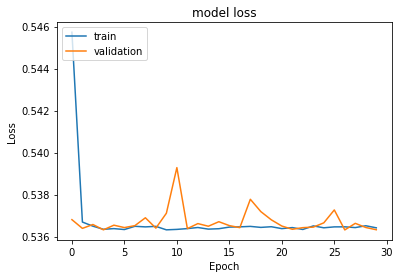

In [43]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
results = model_1.evaluate(X_test, y_test)

301/301 [==============================] - 1s 2ms/step - loss: 0.5363 - mse: 0.1792


- ROC? is binary dont use it
- CM? no not easy to look at
- How?
- Show metrics!! no graph
- how to print macro f1, macro aucroc from sklearnmetrics
- macro is avg of how the model performs on each label of outcome

### NN Model 2 (Oversampling)

In [45]:
y_train.head()

,Junction_1,Junction_2,Junction_3,Junction_4
30256,0,0,1,0
30018,0,0,1,0
33134,0,0,1,0
38627,0,0,1,0
16658,0,1,0,0


In [46]:
# convert y_train to a numpy array
y_train_np = np.array(y_train)

- maybe try not smote oversampling just regular

In [47]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE("minority")
X_train_over, y_train_over = sm.fit_resample(X_train, y_train_np)

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [48]:
print("Before OverSampling, count of junction 1-4': {}".format(sum(y_train_np == 1)))

print("After OverSampling, count of junction 1-4': {}".format(sum(y_train_over == 1)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of junction 1-4': [11664 11655 11710  3467]
After OverSampling, count of junction 1-4': [11664 11655 11710 11710]
After OverSampling, the shape of train_X: (46739, 9)
After OverSampling, the shape of train_y: (46739, 4) 



In [49]:
X_train_over.head(20)

,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
0,5,1.450195e+09,1,2015,12,15,57600,51,4
1,1,1.449338e+09,5,2015,12,5,64800,49,4
2,18,1.460556e+09,2,2016,4,13,50400,15,2
3,21,1.480331e+09,0,2016,11,28,39600,48,4
4,12,1.453774e+09,1,2016,1,26,7200,4,1
5,19,1.473444e+09,4,2016,9,9,64800,36,3
6,34,1.450703e+09,0,2015,12,21,46800,52,4
7,11,1.457539e+09,2,2016,3,9,57600,10,1
8,22,1.487639e+09,1,2017,2,21,3600,8,1
9,23,1.492679e+09,3,2017,4,20,32400,16,2


In [50]:
X_train_over[X_train_over['Day']> 31]

,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter


In [51]:
y_train_over

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [53]:
#Initializing the neural network
model_2 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_2.add(Dense(32,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_2.add(Dropout(0.2))
model_2.add(Dense(16,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_2.add(Dropout(0.2))
# Adding the first hidden layer with 16 neurons with relu as activation functions
model_2.add(Dense(8,activation='softmax'))
# Adding dropout with ratio of 0.1
model_2.add(Dropout(0.1))
# Adding the second hidden layer with 8 neurons with relu as activation functions
model_2.add(Dense(4,activation='softmax'))

In [54]:
# Summary of the model
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                320       
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 4)                

In [55]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.001)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [56]:
#Fitting the ANN 
history_2 = model_2.fit(X_train_over,y_train_over,batch_size=32,epochs=15,verbose=1, validation_data=(X_val,y_val))

Epoch 1/15
1461/1461 [==============================] - 11s 6ms/step - loss: 0.5973 - mse: 0.1902 - val_loss: 0.5654 - val_mse: 0.1890
Epoch 2/15
1461/1461 [==============================] - 7s 5ms/step - loss: 0.5647 - mse: 0.1879 - val_loss: 0.5609 - val_mse: 0.1868
Epoch 3/15
1461/1461 [==============================] - 6s 4ms/step - loss: 0.5635 - mse: 0.1876 - val_loss: 0.5632 - val_mse: 0.1879
Epoch 4/15
1461/1461 [==============================] - 7s 5ms/step - loss: 0.5633 - mse: 0.1876 - val_loss: 0.5624 - val_mse: 0.1875
Epoch 5/15
1461/1461 [==============================] - 6s 4ms/step - loss: 0.5630 - mse: 0.1876 - val_loss: 0.5613 - val_mse: 0.1870
Epoch 6/15
1461/1461 [==============================] - 8s 5ms/step - loss: 0.5629 - mse: 0.1876 - val_loss: 0.5627 - val_mse: 0.1877
Epoch 7/15
1461/1461 [==============================] - 6s 4ms/step - loss: 0.5628 - mse: 0.1875 - val_loss: 0.5615 - val_mse: 0.1871
Epoch 8/15
1461/1461 [==============================] - 8s 6m

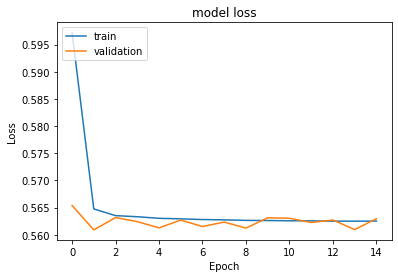

In [57]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
results = model_2.evaluate(X_test, y_test)

301/301 [==============================] - 1s 4ms/step - loss: 0.5629 - mse: 0.1878


### Model 3 (Undersampling)

In [61]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train_np)

In [62]:
print("Before Under Sampling, count of junctions 1-4': {}".format(sum(y_train_np == 1)))
print("After Under Sampling, count of junctions 1-4': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, count of junctions 1-4': [11664 11655 11710  3467]
After Under Sampling, count of junctions 1-4': [3467 3467 3467 3467]
After Under Sampling, the shape of train_X: (13868, 9)
After Under Sampling, the shape of train_y: (13868, 4) 



In [63]:
#Initializing the neural network
model_3 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_3.add(Dense(32,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_3.add(Dropout(0.2))
model_3.add(Dense(16,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
# Adding the first hidden layer with 16 neurons with relu as activation functions
model_3.add(Dense(8,activation='softmax'))
# Adding dropout with ratio of 0.1
model_3.add(Dropout(0.1))
# Adding the second hidden layer with 8 neurons with relu as activation functions
model_3.add(Dense(4,activation='softmax'))

In [64]:
# Summary of the model
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                320       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,020
Trainable params: 1,020
Non-traina

In [65]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.01)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [66]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
history_3 = model_3.fit(X_train_un,y_train_un,batch_size=32,epochs=15,verbose=1, validation_data=(X_val,y_val))

Epoch 1/15
434/434 [==============================] - 4s 7ms/step - loss: 0.5730 - mse: 0.1882 - val_loss: 0.5596 - val_mse: 0.1862
Epoch 2/15
434/434 [==============================] - 3s 7ms/step - loss: 0.5636 - mse: 0.1878 - val_loss: 0.5647 - val_mse: 0.1887
Epoch 3/15
434/434 [==============================] - 2s 5ms/step - loss: 0.5632 - mse: 0.1878 - val_loss: 0.5681 - val_mse: 0.1905
Epoch 4/15
434/434 [==============================] - 2s 5ms/step - loss: 0.5632 - mse: 0.1879 - val_loss: 0.5630 - val_mse: 0.1879
Epoch 5/15
434/434 [==============================] - 2s 5ms/step - loss: 0.5630 - mse: 0.1879 - val_loss: 0.5576 - val_mse: 0.1853
Epoch 6/15
434/434 [==============================] - 2s 5ms/step - loss: 0.5626 - mse: 0.1877 - val_loss: 0.5668 - val_mse: 0.1898
Epoch 7/15
434/434 [==============================] - 3s 8ms/step - loss: 0.5629 - mse: 0.1878 - val_loss: 0.5617 - val_mse: 0.1872
Epoch 8/15
434/434 [==============================] - 2s 5ms/step - loss: 0.

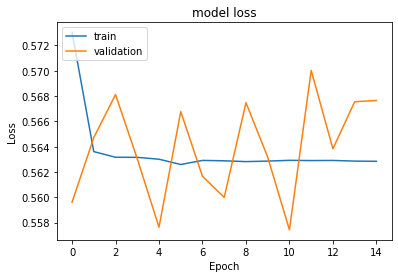

In [67]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
results = model_1.evaluate(X_val, y_val)

301/301 [==============================] - 1s 3ms/step - loss: 0.5363 - mse: 0.1792


### Testing ROC and CM below

In [ ]:
y_pred_test = model_3.predict(X_val)

In [ ]:
# y_pred=model_3.predict(X_val) 
# y_pred=np.argmax(y_pred, axis=1)
# y_test=np.argmax(y_val, axis=1)
# cm = confusion_matrix(y_test, y_pred)

In [ ]:
# cm = confusion_matrix(y_val, y_pred_test)

In [ ]:
# # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
# cm_df = pd.DataFrame(cm,
#                      index = ['SETOSA','VERSICOLR','VIRGINICA'], 
#                      columns = ['SETOSA','VERSICOLR','VIRGINICA'])

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Predict probabilities for the validation set
# y_pred = model_3.predict(X_val)

# # Calculate ROC curve and AUC for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_val.iloc[:, i], y_pred[:, i])
#     roc_auc[i] = roc_auc_score(y_val.iloc[:, i], y_pred[:, i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_val.to_numpy().ravel(), y_pred.ravel())
# roc_auc["micro"] = roc_auc_score(y_val.to_numpy(), y_pred, average="micro")

# # Plot ROC curve for each class and micro-average ROC curve
# import matplotlib.pyplot as plt
# plt.figure()
# lw = 2
# colors = ['red', 'green', 'blue', 'purple']
# for i, color in zip(range(4), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve (area = %0.2f) for label %d' % (roc_auc[i], i+1))
# plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle='--',
#          label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for multi-label classification')
# plt.legend(loc="lower right")
# plt.show()

- drop extraneous features
- scale?
- try not sampling?
- leaky relu
- regularization (l1, l2, dropout) add regularization term to loss function
- lowring model complexity
- increase train data?
- early stopping
- hyperperameter tuning


- CM?
- HOW TO MAKE AOC

In [ ]:
# #Initializing the neural network
# model_3 = Sequential()
# #Adding the input layer with 32 neurons and relu as activation function
# model_3.add(Dense(128,activation='relu',input_dim = 9))
# # Adding dropout with ratio of 0.2
# model_3.add(Dropout(0.2))
# # Adding the first hidden layer with 16 neurons with relu as activation functions
# model_3.add(Dense(64,activation='ELU'))
# # Adding dropout with ratio of 0.1
# model_3.add(Dropout(0.1))
# model_3.add(Dense(32,activation='sigmoid'))
# # Adding dropout with ratio of 0.1
# model_3.add(Dropout(0.1))
# model_3.add(Dense(16,activation='ELU'))
# # Adding dropout with ratio of 0.1
# model_3.add(Dropout(0.1))
# # Adding the second hidden layer with 8 neurons with relu as activation functions
# model_3.add(Dense(4,activation='sigmoid'))